__Purpose:__ Introduce Personalized Federated Learning, specifically by implementing APFL on our dataset and then trying other methods.
<br>
1. We are still assuming we can test on the second half (updates 10-19ish) since (human/co-adaptive) learning should be complete by then!  For reasons shown in earlier NBs

In [1]:
import pandas as pd
import os
import numpy as np
import random
from matplotlib import pyplot as plt
from scipy.optimize import minimize
import copy

from experiment_params import *
from cost_funcs import *
from fl_sim_classes import *
import time
import pickle
from sklearn.decomposition import PCA

In [2]:
path = r'C:\Users\kdmen\Desktop\Research\personalization-privacy-risk\Data'
cond0_filename = r'\cond0_dict_list.p'
all_decs_init_filename = r'\all_decs_init.p'
nofl_decs_filename = r'\nofl_decs.p'
id2color = {0:'lightcoral', 1:'maroon', 2:'chocolate', 3:'darkorange', 4:'gold', 5:'olive', 6:'olivedrab', 
            7:'lawngreen', 8:'aquamarine', 9:'deepskyblue', 10:'steelblue', 11:'violet', 12:'darkorchid', 13:'deeppink'}
implemented_client_training_methods = ['EtaGradStep', 'EtaScipyMinStep', 'FullScipyMinStep']
implement_these_methods_next = ['APFL', 'AFL', 'PersA_FL_MAML', 'PersA_FL_ME', 'PFA']
num_participants = 14

# For exclusion when plotting later on
bad_nodes = [1,3,13]

with open(path+cond0_filename, 'rb') as fp:
    cond0_training_and_labels_lst = pickle.load(fp)

D_0_7 = np.random.rand(2,7)

# Testing APFL

Testing the APFL Implementation

In [3]:
user_c0_APFL = [Client(i, D_0_7, 'NAN', cond0_training_and_labels_lst[i], 'streaming', num_steps=10, delay_scaling=0, global_method='APFL') for i in range(14)]
global_model_APFL = Server(1, D_0_7, 'APFL', user_c0_APFL, num_steps=10)

global_model_APFL.execute_FL_loop()

In [4]:
for i in range(20):
    global_model_APFL.execute_FL_loop()
    #print(f"ROUND {i}")
    #for my_client in global_model_APFL.chosen_clients_lst:
    #    # So since APFL sets the chosen_clients_lst AFTER it runs instead of before each iter, the following line can actually fail...
    #    #print(round(np.linalg.norm(( my_client.F@np.transpose(my_client.F) + my_client.alphaD*np.identity(my_client.F.shape[0]))), 3))
    #print(global_model_APFL.current_round)
    #print(len(global_model_APFL.global_error_log))
    #print()

In [5]:
for i in range(num_participants):
    try:
        user_c0_APFL[i].F.shape
        # If it works then break the loop
        break
    except AttributeError:
        pass

print(i)

0


In [6]:
#i = 0
# This should be the same i as the above loop

print(f"F.shape: {user_c0_APFL[i].F.shape}")
print(f"Norm: {np.linalg.norm(user_c0_APFL[i].F)}")
print(f"Sum: {np.sum((user_c0_APFL[i].F))}")
print(f"**2 Sum: {np.sum((user_c0_APFL[i].F)**2)}")

F.shape: (7, 600)
Norm: 11.603236952809484
Sum: -0.890778764188731
**2 Sum: 134.6351077830435


In [7]:
print("Decs")
print(user_c0_APFL[i].local_w)
print(user_c0_APFL[i].global_w)
diff = user_c0_APFL[i].local_w - user_c0_APFL[i].global_w
print(diff)
print()
print("Gradient")
out = gradient_cost_l2(user_c0_APFL[i].F, user_c0_APFL[i].mixed_w, user_c0_APFL[i].H, user_c0_APFL[i].V, user_c0_APFL[i].learning_batch, user_c0_APFL[i].alphaF, user_c0_APFL[i].alphaD, Ne=7)
print(out.shape)
print(out)

Decs
[[0.73983159 0.88153219 0.40972142 0.70073796 0.63069285 0.54266225
  0.90049639]
 [0.61049051 0.02360698 0.63218091 0.47213346 0.02742422 0.13120007
  0.34924024]]
[[2.95906309 3.52583431 1.63875199 2.80272362 2.52256703 2.17047298
  3.6016933 ]
 [2.44174457 0.0944178  2.52851732 1.88838008 0.10968788 0.5247578
  1.39684788]]
[[-2.2192315  -2.64430212 -1.22903057 -2.10198567 -1.89187418 -1.62781074
  -2.70119691]
 [-1.83125406 -0.07081083 -1.89633641 -1.41624662 -0.08226366 -0.39355773
  -1.04760764]]

Gradient
(14,)
[-0.00634522 -0.00718405 -0.00324682 -0.00555634 -0.00499468 -0.00429874
 -0.00713583 -0.00520283 -0.00024198 -0.00501857 -0.00374515 -0.00021841
 -0.00103709 -0.00276311]


In [8]:
np.inner(diff.flatten(), out.flatten())

0.11215679786792376

Run loop

In [9]:
big_loop_iters = 1000
for i in range(big_loop_iters):
    global_model_APFL.execute_FL_loop()
    
print("(Current Local Round, Current Local Update)")
for my_client in global_model_APFL.all_clients:
    print((my_client.current_round, my_client.current_update))

C:\Users\kdmen\Desktop\Research\personalization-privacy-risk\fl_sim_classes.py:542: RuntimeWarning: overflow encountered in multiply
  self.mixed_w = self.adap_alpha[-1]*self.local_w - (1 - self.adap_alpha[-1]) * self.global_w
C:\Users\kdmen\Desktop\Research\personalization-privacy-risk\cost_funcs.py:41: RuntimeWarning: invalid value encountered in matmul
  term1 = (np.linalg.norm((D@F + H@Vminus - Vplus))**2)*(alphaE)
C:\Users\kdmen\Desktop\Research\personalization-privacy-risk\cost_funcs.py:23: RuntimeWarning: invalid value encountered in matmul
  return ((2*(D@F + H@Vminus - Vplus)@F.T*(alphaE) + 2*alphaD*D ).flatten())
C:\Users\kdmen\Desktop\Research\personalization-privacy-risk\fl_sim_classes.py:542: RuntimeWarning: invalid value encountered in subtract
  self.mixed_w = self.adap_alpha[-1]*self.local_w - (1 - self.adap_alpha[-1]) * self.global_w
C:\Users\kdmen\Desktop\Research\personalization-privacy-risk\fl_sim_classes.py:542: RuntimeWarning: overflow encountered in multiply
  se

(Current Local Round, Current Local Update)
(135, 12)
(117, 12)
(145, 12)
(162, 13)
(162, 13)
(144, 12)
(108, 12)
(135, 12)
(126, 12)
(117, 12)
(144, 12)
(118, 12)
(108, 12)
(117, 12)


In [10]:
user_c0_APFL[0].adap_alpha[:22]

[0.01,
 0.010013192151570746,
 0.009987318693372578,
 0.009961444584102625,
 0.00993556982376144,
 0.009909694412349568,
 0.009883818349867563,
 0.009857941636315978,
 0.009832064271695366,
 0.009806186256006282,
 0.009728545132888563,
 0.0095727462778764,
 0.009416918324663601,
 0.009261061268085,
 0.009105175102974592,
 0.008949259824165534,
 0.008793315426490134,
 0.008637341904779865,
 0.008481339253865357,
 -1.695065943528214,
 -38026.633573728745,
 -536576472.932253]

In [11]:
print(f"F.shape: {user_c0_APFL[0].F.shape}")
print(f"Norm: {np.linalg.norm(user_c0_APFL[0].F)}")
print(f"Sum: {np.sum((user_c0_APFL[0].F))}")
print(f"**2 Sum: {np.sum((user_c0_APFL[0].F)**2)}")

F.shape: (7, 600)
Norm: 14.484250454580117
Sum: -0.7574490359511259
**2 Sum: 209.79351123100432


In [12]:
print(user_c0_APFL[0].local_w)
print(user_c0_APFL[0].global_w)
diff = user_c0_APFL[0].local_w - user_c0_APFL[0].global_w
print(diff)
out = gradient_cost_l2(user_c0_APFL[0].F, user_c0_APFL[0].mixed_w, user_c0_APFL[0].H, user_c0_APFL[0].V, user_c0_APFL[0].learning_batch, user_c0_APFL[0].alphaF, user_c0_APFL[0].alphaD, Ne=7)
print(out.shape)
print(out)

[[nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan]]
[[nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan]]
[[nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan]]
(14,)
[nan nan nan nan nan nan nan nan nan nan nan nan nan nan]


In [13]:
np.inner(diff.flatten(), out.flatten())

nan

Plot

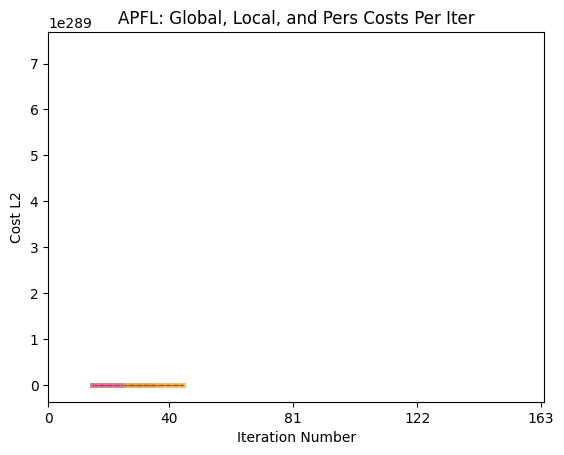

In [14]:
condensed_external_plotting(user_c0_APFL, 'local', pers_error=True, show_update_change=False, custom_title="APFL: Global, Local, and Pers Costs Per Iter")

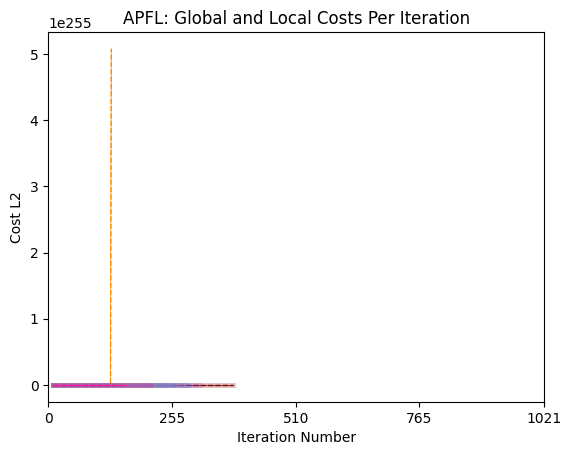

In [15]:
condensed_external_plotting(global_model_APFL, 'global', pers_error=True, show_update_change=False, custom_title="APFL: Global and Local Costs Per Iteration")

In [16]:
global_model_APFL.current_round

1021

In [17]:
#client_loss.append(input_data.global_error_log[j][i][2])
len(global_model_APFL.global_error_log)

2347

In [18]:
len(global_model_APFL.local_error_log)

2347

In [19]:
len(global_model_APFL.personalized_error_log)

2347

Re-running but with input learning rate (eta) of 0.00001 (didn't work by itself)

Now also fix alpha (not adaptive anymore)

Now set eta to 0.000000001

In [42]:
my_learning_rate = 0.0000000000000000000000000000001
print(my_learning_rate)

1e-31


In [43]:
user_c0_APFL = [Client(i, D_0_7, 'NAN', cond0_training_and_labels_lst[i], 'streaming', input_eta=True, num_steps=10, adaptive=False, eta=my_learning_rate, delay_scaling=0, global_method='APFL') for i in range(14)]
global_model_APFL = Server(1, D_0_7, 'APFL', user_c0_APFL, num_steps=10)

global_model_APFL.execute_FL_loop()

In [44]:
for i in range(20):
    global_model_APFL.execute_FL_loop()

In [45]:
for i in range(big_loop_iters):
    global_model_APFL.execute_FL_loop()
    
print("(Current Local Round, Current Local Update)")
for my_client in global_model_APFL.all_clients:
    print((my_client.current_round, my_client.current_update))

(Current Local Round, Current Local Update)
(154, 13)
(126, 12)
(135, 12)
(126, 12)
(144, 12)
(154, 13)
(126, 12)
(126, 12)
(108, 12)
(117, 12)
(198, 13)
(117, 12)
(99, 11)
(108, 12)


In [46]:
user_c0_APFL[0].adap_alpha[:22]

[0.25]

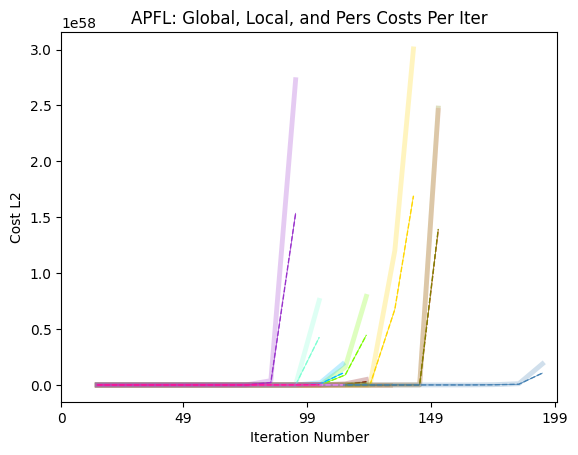

In [47]:
condensed_external_plotting(user_c0_APFL, 'local', pers_error=True, show_update_change=False, custom_title="APFL: Global, Local, and Pers Costs Per Iter")

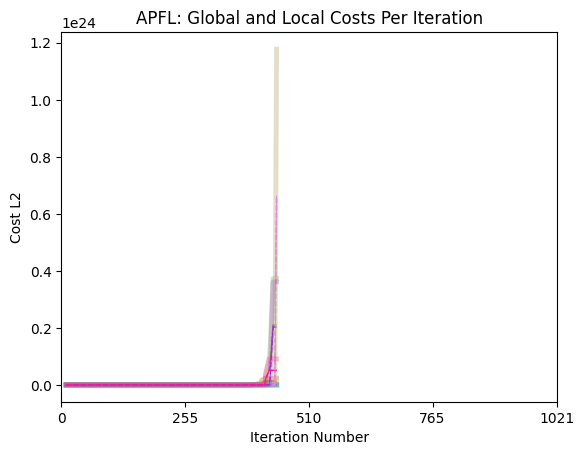

In [48]:
condensed_external_plotting(global_model_APFL, 'global', pers_error=True, show_update_change=False, custom_title="APFL: Global and Local Costs Per Iteration")

In [27]:
assert(1==0)

AssertionError: 

# DEVELOPMENT

# Personalized FL Algorithms
ALL PERSONALIZATION ALGORITHMS
1. APFL
1. Cesar/Taha: AFL
1. Cesar/Taha: PersA-FL MAML
1. Cesar/Taha: PersA-FL ME
1. PFA: PP F Adaptation for Effective Model Personalization
1. Pers RT FL for Epileptic Seizure Detection
1. An Efficient Framework for Clustered FL
1. Pers FL with DP
## Adaptive Personalized FL Testing Ground

Adapting their code to actually be able to be run in something other than top-down server-only approach
> Their Github: https://github.com/MLOPTPSU/FedTorch <br>
> APFL link: https://github.com/MLOPTPSU/FedTorch/blob/ab8068dbc96804a5c1a8b898fd115175cfebfe75/fedtorch/comms/trainings/federated/apfl.py#L33

loss.backward() computes dloss/dx for every parameter x which has requires_grad=True. These are accumulated into x.grad for every parameter x. Loss.backward() does not update the weights, only computes the gradients.  The graph is used by loss.backward() to compute gradients.  In pseudo-code: x.grad += dloss/dx

optimizer.step updates the value of x using the gradient x.grad. For example, the SGD optimizer performs:

x += -lr * x.grad
optimizer.zero_grad() clears x.grad for every parameter x in the optimizer. It’s important to call this before loss.backward(), otherwise you’ll accumulate the gradients from multiple passes.

optimizer.zero_grad() and optimizer.step() do not affect the graph of autograd objects. They only touch the model’s parameters and the parameter’s grad attributes.

If you have multiple losses (loss1, loss2) you can sum them and then call backwards once:

loss3 = loss1 + loss2
loss3.backward()

In [ ]:
#python run_mpi.py -f -ft apfl -n 10 -d mnist -lg 0.1 -b 50 -c 20 -k 1.0 -fs local_step -l 10 -r 2 -pa 0.5 -fp
#'--num_epochs': args.num_epochs_per_comm * args.num_comms,

# num_epochs_per_comm=1
# num_clients=20
# batch_size=50
# num_comms=100
# lr_gamma=1.0
# lr_mu = 1

## Personalized Asynchronous Federated Learning (Taha+Cesar)
> https://arxiv.org/pdf/2210.01176.pdf

In [ ]:
assert(1==0)

Basic AFL
> My code is not configured to run this way, although this way is the most realistic (server waits for client responses).  Ideally would have some way to weight different clients if there are some that are spamming, or generally just faster than others and contributing more.

In [ ]:
# Repeat until converged...
# how do you know in a decentralized way lol
#if self.update_recieved:
#    self.w -= self.beta*self.latest_update

Personalized AFL
> 3 Methods (1 is just vanilla AFL)

In [ ]:
#input: number of local steps Q, local stepsize η, MAML stepsize α, Moreau Envelope (ME) regularization parameter λ, minimum batch size b, estimation error ν.

# Do client selection

for my_client in self.chosen_clients_lst:
    my_client.global_w = self.w
    for q in range(Q):
        #"Sample a data batch D_{i, q} from distribution p_i"
        
        # OPTION A (AFL) --> Just what is shown in the cell above
        if self.global_method=='AFL':
            # Server doesn't have client's grad input info... eg FDHV
            # In their model/code, does the client send the params or the new weight?
            
            # Eqn 5 is the original
            # Eqn 9 is the biased estimation of 5, shown below
            self.w -= self.eta*gradient_cost_l2(self.F,self.D,self.H,self.V,self.learning_batch,self.alphaF,self.alphaD)
        # OPTION B (PersA-FL: MAML)
        elif self.global_method=='PersA_FL_MAML':
            #"Sample 2 databatches from distribution p_i"
            # I have no idea what these terms are lol
            # I don't think I can use the analytical cost funcs here either now
            self.w -= self.eta*(I-alpha*Hessian(self.w, D_dd))*grad(self.w-alpha*grad(D_d), D)
        # OPTION C (PersA-FL: ME)
        elif self.global_method=='PersA_FL_ME':
            self.h = f(theta_i, D) + lambda*0.5*(np.linalg.norm(theta_i - self.w)^2)
            #"Minimize h wrt theta_i up to accuracy level v to find theta_tilde_i"
            #np.linalg.norm(grad_h(theta_tilde_i(self.w), self.w, D)) <= v
            #scipy.minimize(...)
            self.w -= self.eta*lambda*(self.w - theta_tilde_i(self.w))
        
        # ELSE
        else:
            print(f'Global method {self.method} not defined, please select one from the following: {self.implemented_global_training_methods}')
delta_i = self.w_i_0 - self.w_i_Q
# client i broadcasts delta_i to the server
#"Repeat until not interrupted by the server"